<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving pic.JPEG to pic.JPEG

Upload Style Image


Saving impasto_landscape.jpeg to impasto_landscape.jpeg
Content Path: <_io.BytesIO object at 0x7f056cbf3650>
Style Path: <_io.BytesIO object at 0x7f056cbe1d70>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

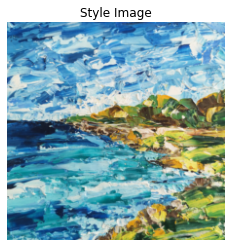

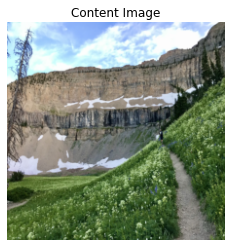

In [60]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

**DONE:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image



In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = mean.clone().detach().view(-1, 1, 1)
      self.std = std.clone().detach().view(-1, 1, 1)
    #   self.mean = torch.tensor(mean).view(-1, 1, 1)
    #   self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(weights='DEFAULT').features.eval()
    print([c for c in self.vgg.children()])
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [245]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3", "maxpool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3", "maxpool4", 
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3", "maxpool5"]

# Choose the layers to use for style and content transfer
content_layer_idx = 2
# style_layer_idx = [2, 7, 14, 21, 28]
style_layer_idx = [14, 21, 28]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
model = VGGIntermediate([content_layer_idx] + style_layer_idx)
model.requires_grad_(requires_grad=False)
model = model.cuda()

# Cache the outputs of the content and style layers for their respective images
content_layer = model.forward(content_image)[content_layer_idx].clone().detach()
style_layers = [model.forward(style_image)[idx].clone().detach() for idx in style_layer_idx]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

**DONE:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object


In [246]:
def gram_matrix(input):
	b, c, h, w = input.size()
	tran = torch.transpose(input, 2, 3)
	return torch.matmul(input, tran)


# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
class ContentLoss(nn.Module):
	def __init__(self):
		super(ContentLoss, self).__init__()

	def forward(self, gen_image):
		return ((gen_image - content_layer)**2).sum() / 2


# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
class StyleLoss(nn.Module):
	def __init__(self):
		super(StyleLoss, self).__init__()

	def forward(self, gen_image):
		def E(A, G):
			b, c, h, w = A.size()
			N, M = c, h*w
			A, G = gram_matrix(A), gram_matrix(G)
			return ((A - G)**2).sum() / (4 * N**2 * M**2)

		# technically I should divide by 5, but I will just include this in the beta term
		return sum([E(A, G) for A, G in zip(style_layers, gen_image)]) / len(style_layer_idx)

In [247]:
class TotalLoss(nn.Module):
    def __init__(self):
        super(TotalLoss, self).__init__()
        self.con_loss = ContentLoss()
        self.stl_loss = StyleLoss()
        self.beta = 1e8
        self.cur_con_loss = None
        self.cur_stl_loss = None

    def forward(self, gen_images):
        self.cur_con_loss = self.con_loss.forward(gen_images[content_layer_idx])
        self.cur_stl_loss = self.stl_loss.forward([gen_images[idx] for idx in style_layer_idx])
        return self.cur_con_loss + self.beta*self.cur_stl_loss

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

**DONE:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image



In [248]:
# Start with a copy of the content image
gen_image = content_image.clone()
gen_image.requires_grad_()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors

# initialize
num_epoch = 100
objective = TotalLoss()
optimizer = optim.Adam([gen_image], lr=.005)
c_loss = []
s_loss = []

# loop
loop = tqdm(total=num_epoch, leave=False)
for epoch in range(1, num_epoch+1):

    # clip image
    with torch.no_grad():
        gen_image.clamp_(0, 1)

    # optimize
    optimizer.zero_grad()
    layers = model(gen_image)
    loss = objective(layers)
    loss.backward()
    optimizer.step()

    # save loss
    c_loss.append(objective.cur_con_loss.item())
    s_loss.append(objective.cur_stl_loss.item())

    # update loop
    loop.set_description(
        'epoch:{}, content loss:{:.4f}, style loss:{:.4f}'.format(epoch, c_loss[-1], s_loss[-1]))
    loop.update(True)

    # if (epoch % 10) == 0:
    #     plt.figure()
    #     display(gen_image)
    #     plt.show()

loop.close()

# clip image
with torch.no_grad():
    gen_image.clamp_(0, 1)

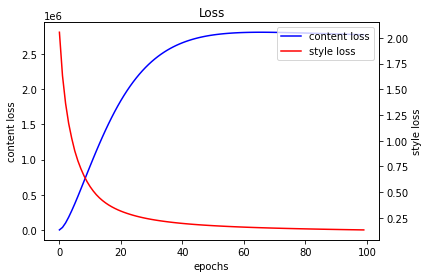

In [250]:
# plot loss
ax1 = plt.subplot()
l1, = ax1.plot(c_loss, 'b')
ax1.set_ylabel('content loss')

ax2 = ax1.twinx()
l2, = ax2.plot(s_loss, 'r')
ax2.set_ylabel('style loss')
ax1.set_xlabel('epochs')


plt.title('Loss')
plt.legend([l1, l2], ['content loss', 'style loss'])
plt.show()

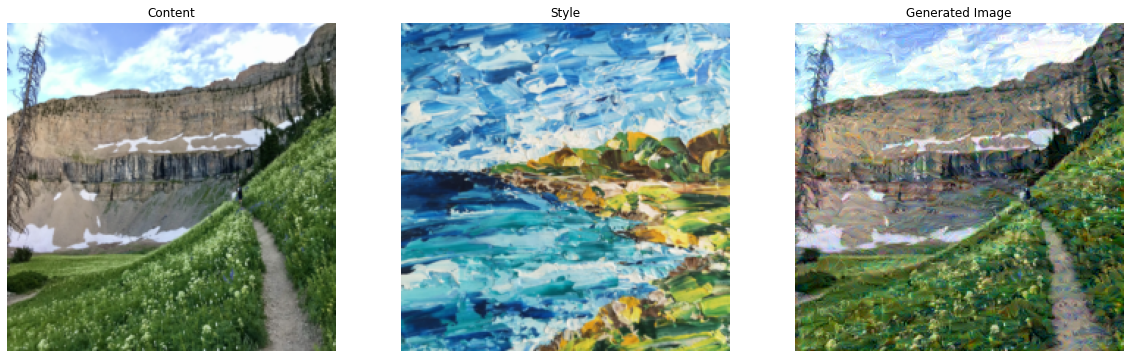

In [251]:
# show image
plt.figure(figsize=(20,8))
plt.subplot(131)
display(content_image, 'Content')
plt.subplot(132)
display(style_image, 'Style')
plt.subplot(133)
display(gen_image, 'Generated Image')
plt.show()

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

**DONE:**
- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

1.
Passing the original image through the model gives us $[F^1, F^2, ...]$ where $F^l$ corresponds to the $l^{th}$ layer returned by the model. Passing the generated image through the model gives us $[P^1, P^2, ...]$ where $P^l$ corresponds to the $l^{th}$ layer returned by the model. Taking the MSE of the differece between each $F^l$ and $P^l$ for each element in them gives us the content loss. (The $i, j$ are self explanitory, but I'll describe them anyway. The $i, j$ in the sum refer to the $j^{th}$ element in the $i^{th}$ column. Summing over these is what gives us the MSE.)

3.
$G^l_{ij}$ is the $j^{th}$ element in the $i^{th}$ column of the gram matrix generated by layer $l$. Given a layer returned by the model, $F^l$, $G^l_{ij}$ is equal to the dot product of the $i^{th}$ row and the $j^{th}$ column of F^l$.

4.
$G^l_{ij}$ is the $j^{th}$ element in the $i^{th}$ column of the gram matrix generated by layer $l$ of the style image. $A^l_{ij}$ is the $j^{th}$ element in the $i^{th}$ column of the gram matrix generated by layer $l$ of the generated image. Taking the MSE (this is explained more in 1.) of the difference between the two, then dividing that by the 4 times the number of filters squared ($N^2_l$) times the size ($l \times w$) squared ($M^2_l$) gives us $E_l$.

5.
Taking the weighted average of the $E_l$'s described in 4. gives us the style loss.